In [11]:
import numpy as np
import matplotlib.pyplot as plt

import HQStyle
HQStyle.import_all()

/home/gsilvi/Projects/hqstyle/HQStyle/basic_imports.py:39: UserWarning: Trying to register the cmap 'mutedmagma' which already exists.
  register_cmap(tmp_name, cmap)


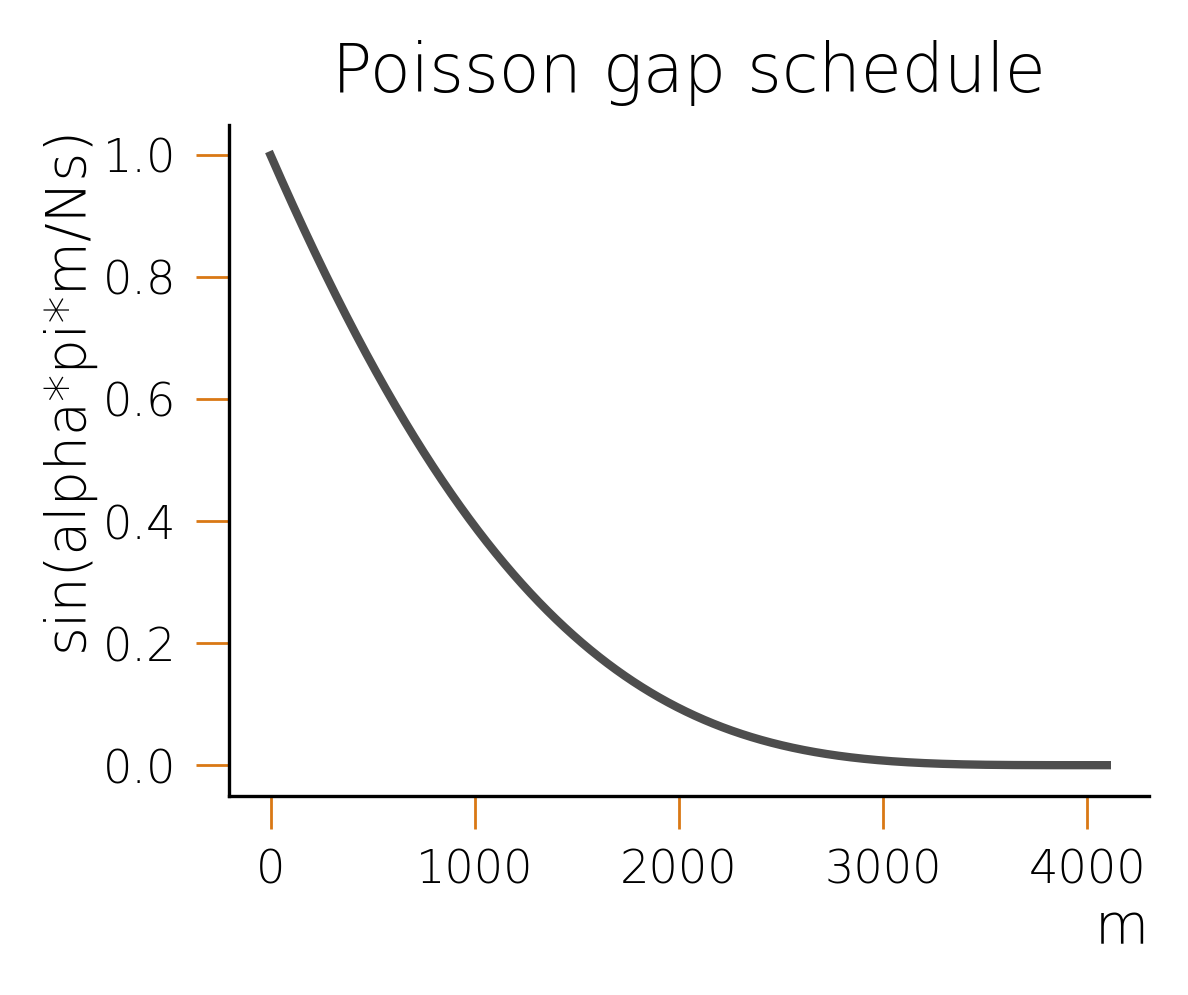

In [12]:
def poisson_gap(alpha, Ns):
    m = np.arange(1,Ns+1)
    return (1-np.sin(alpha*np.pi*m/Ns))**2 # added 1- and squared

#Plot the function:

alpha = 0.5
Ns = 4096

plt.plot(poisson_gap(alpha, Ns,))
plt.xlabel('m')
plt.ylabel('sin(alpha*pi*m/Ns)')
plt.title('Poisson gap schedule')
plt.show()


#The below function is generating a random distribution of points on a circle.
#The function takes three arguments: s, p, and z.
#s is the seed for the random number generator.
#p is the number of points to be generated.
#z is the number of points to be generated on the circle.
#The function returns an array of p points on the circle.
#The function uses the poisson function to generate a random number of points
#between each point.
#The function then adjusts the mean of the poisson distribution until the
#number of points generated is equal to p.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random

def poisson(lmbd):
    L = np.exp(-lmbd)
    k = 0
    p = 1
    while p >= L:
        u = random.random()
        p *= u
        k += 1
    return k-1

def main(s, p, z):
    ld = z/p
    adj = 2*(ld-1)
    random.seed(s)
    v = np.zeros(z)
    while True:
        i = 0
        n = 0
        while i < z:
            v[n] = i
            i += 1
            k = poisson(adj*np.sin((i+0.5)/(z+1)*np.pi/2))
            i += k
            n += 1
        if n > p:
            adj *= 1.02
        if n < p:
            adj /= 1.02
        if n == p:
            break
    return v[:p]

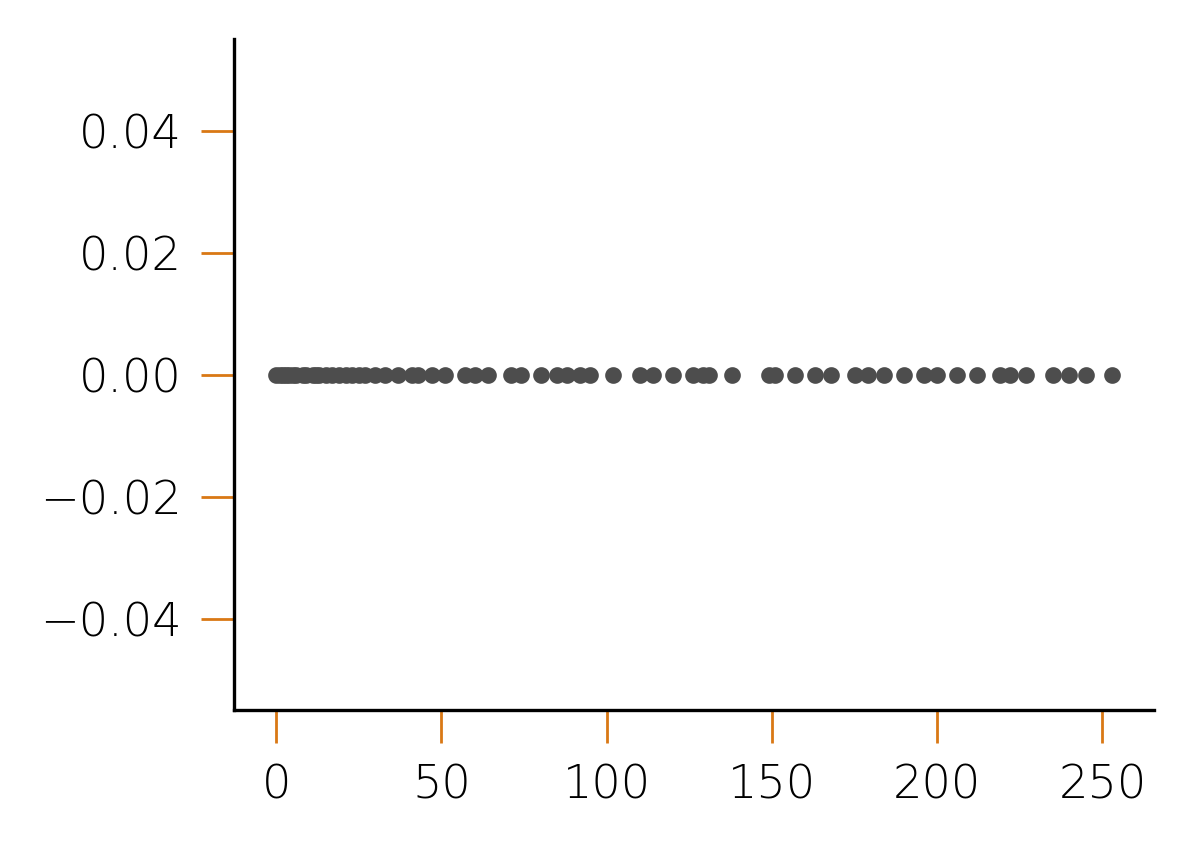

In [14]:
s = 1.0
p = 64
z = 256
v = main(s, p, z)
plt.plot(v, np.zeros(len(v)), 'o')
plt.show()

In [15]:
import numpy as np 
from scipy import linalg 
# Generate a long, sparse signal 
x = np.zeros(100000) 
x[np.random.randint(0, 100000, 1000)] = np.random.randn(1000) 
# Use compressed sensing to sample and reconstruct the signal 
y = linalg.lstsq( np.random.randn( 100000 , 1000 ), x )[ 0 ] 
x_hat = np.dot( y , np.random.randn( 1000 , 100000 ))

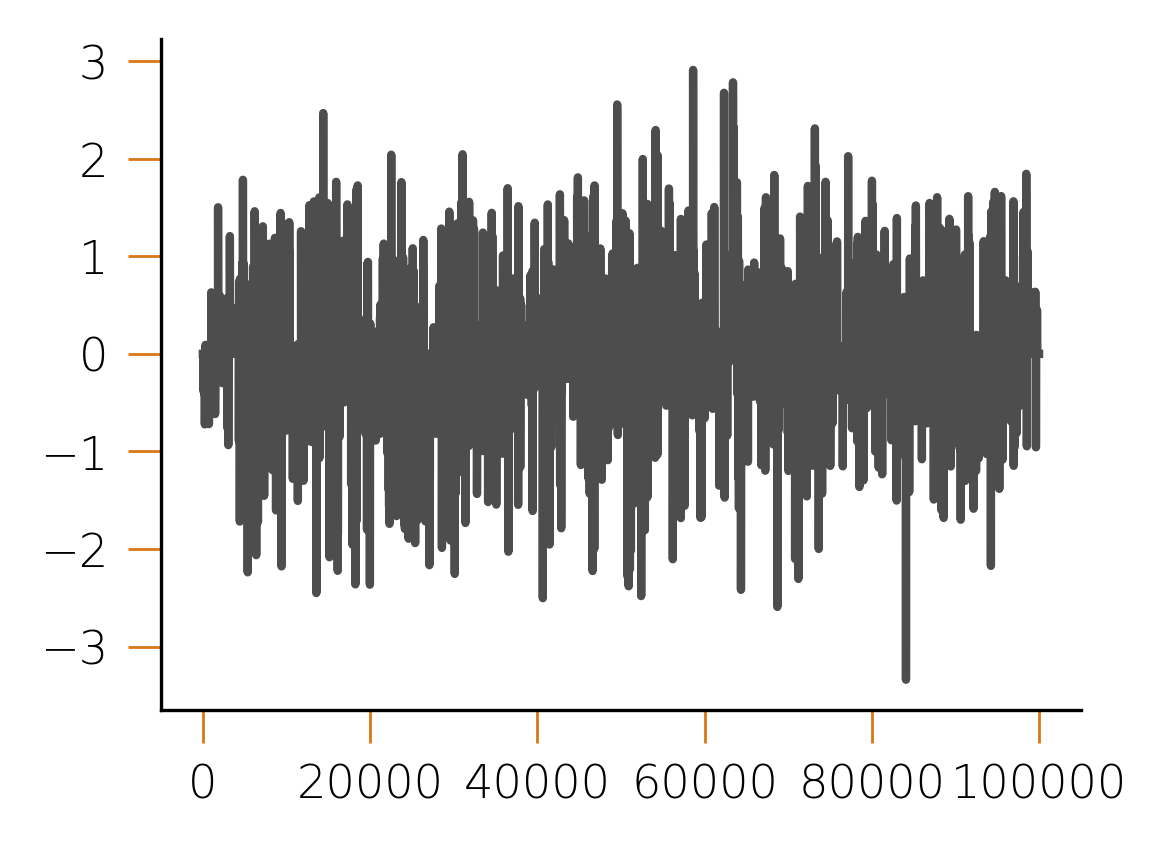

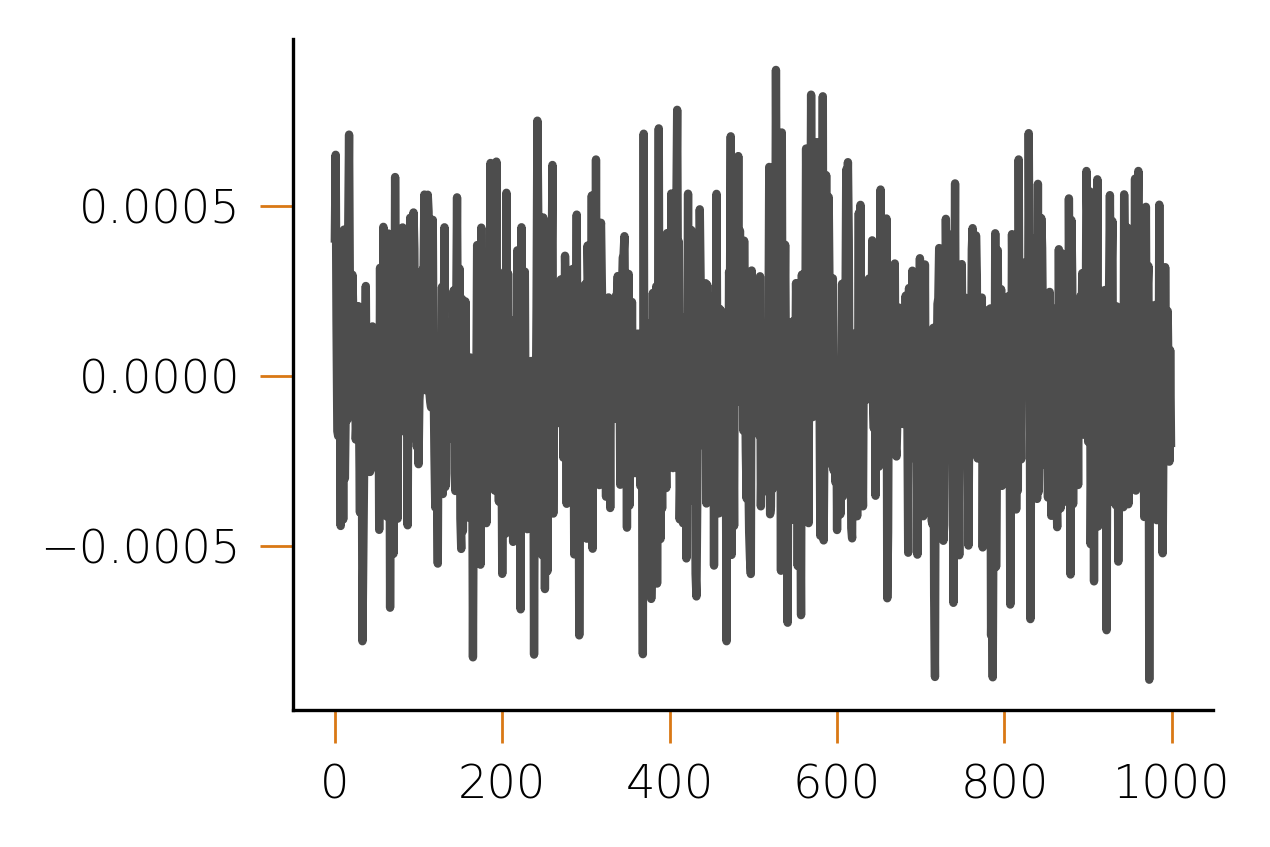

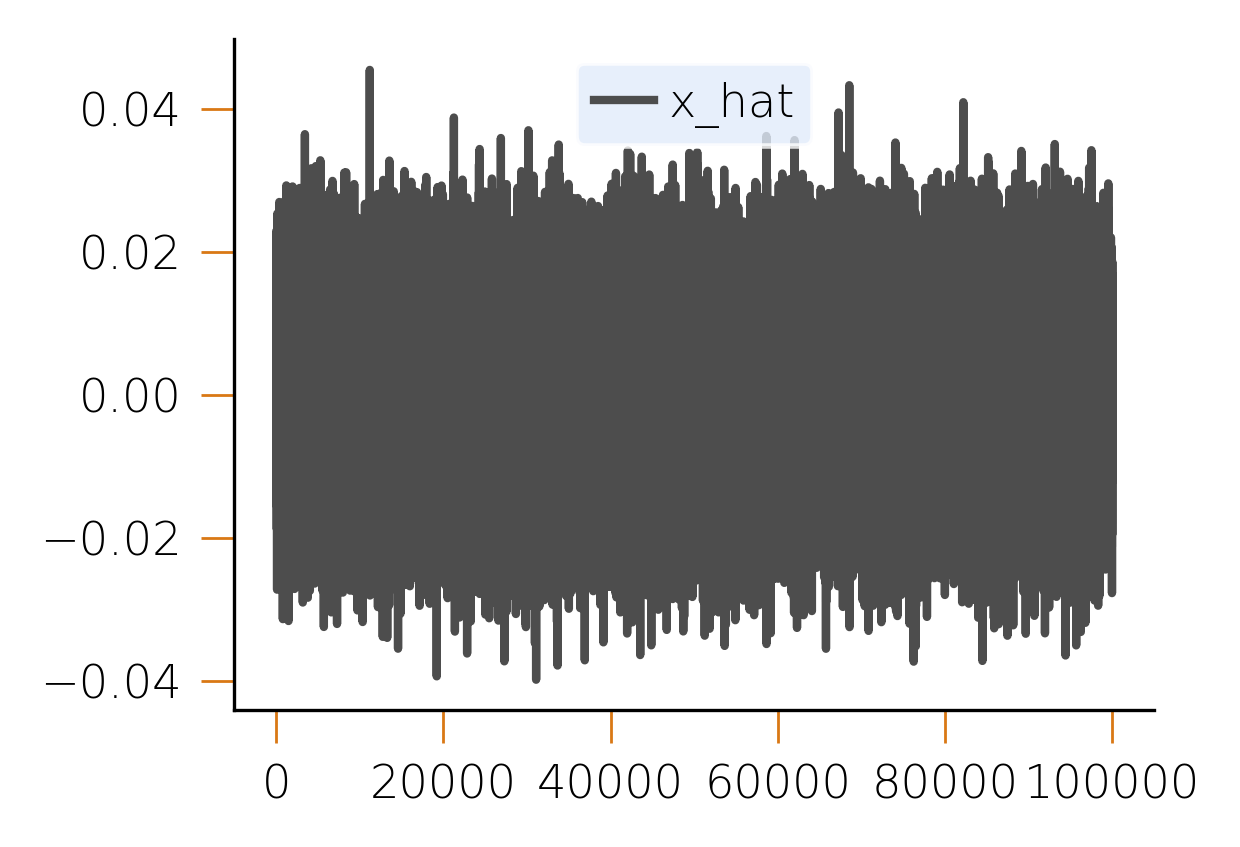

In [16]:
plt.plot(x, label='x')
plt.figure()
plt.plot(y, label='y')
plt.figure()
plt.plot(x_hat, label='x_hat')
plt.legend()

In [17]:
# make sure you've got the following packages installed
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx

First what we’re going to do is create some arbitrary linear data including some noise. Let’s use the made-up equation:

y=15x+3+ϵ

where ϵ is some normally distributed error with standard deviation σ=0.1.

In [18]:
# generate some data with noise
x = np.sort(np.random.uniform(0, 10, 15))
y = 3 + 0.2 * x + 0.1 * np.random.randn(len(x))

Now let’s fit two lines to the data samples. For the first line, we’ll use the L1 norm as the criterion for a good fit; for the second line, we’ll use the L2 norm.

Optimization terminated successfully.
         Current function value: 1.157303
         Iterations: 51
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: 0.141963
         Iterations: 49
         Function evaluations: 95


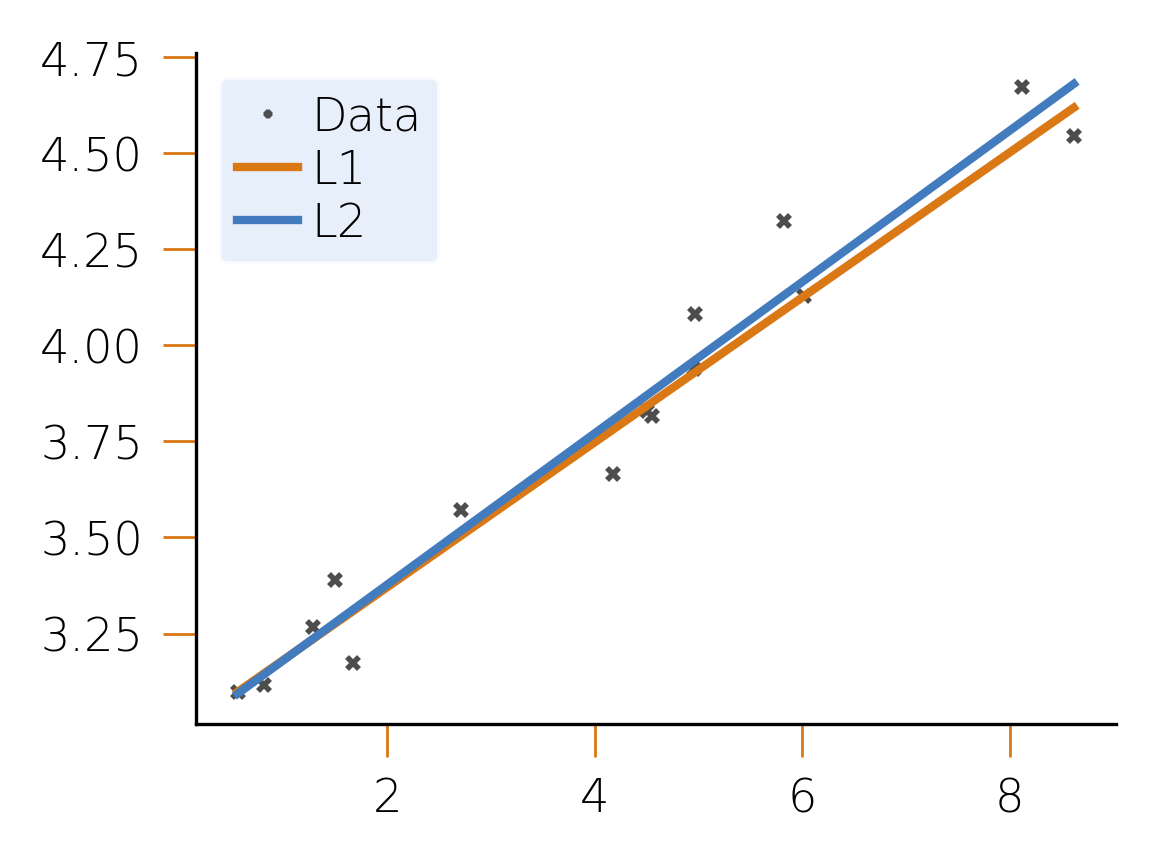

In [19]:
# find L1 line fit
l1_fit = lambda x0, x, y: np.sum(np.abs(x0[0] * x + x0[1] - y))
xopt1 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y))

# find L2 line fit
l2_fit = lambda x0, x, y: np.sum(np.power(x0[0] * x + x0[1] - y, 2))
xopt2 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y))

plt.plot(x,y, marker='x',linestyle='None', label='Data')
plt.plot(x,xopt1[0]*x +xopt1[1], label= 'L1')
plt.plot(x,xopt2[0]*x +xopt2[1], label= 'L2')
plt.legend()

Now, let’s get a tad crazy and add some outliers. In other words, let’s perturb a couple of the points, moving them far away from the lines. This isn’t actually all that out of the ordinary if you think about it. Outliers frequently occur in real world data, causing all kinds of headaches.

Optimization terminated successfully.
         Current function value: 7.831523
         Iterations: 56
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: 19.907127
         Iterations: 50
         Function evaluations: 94


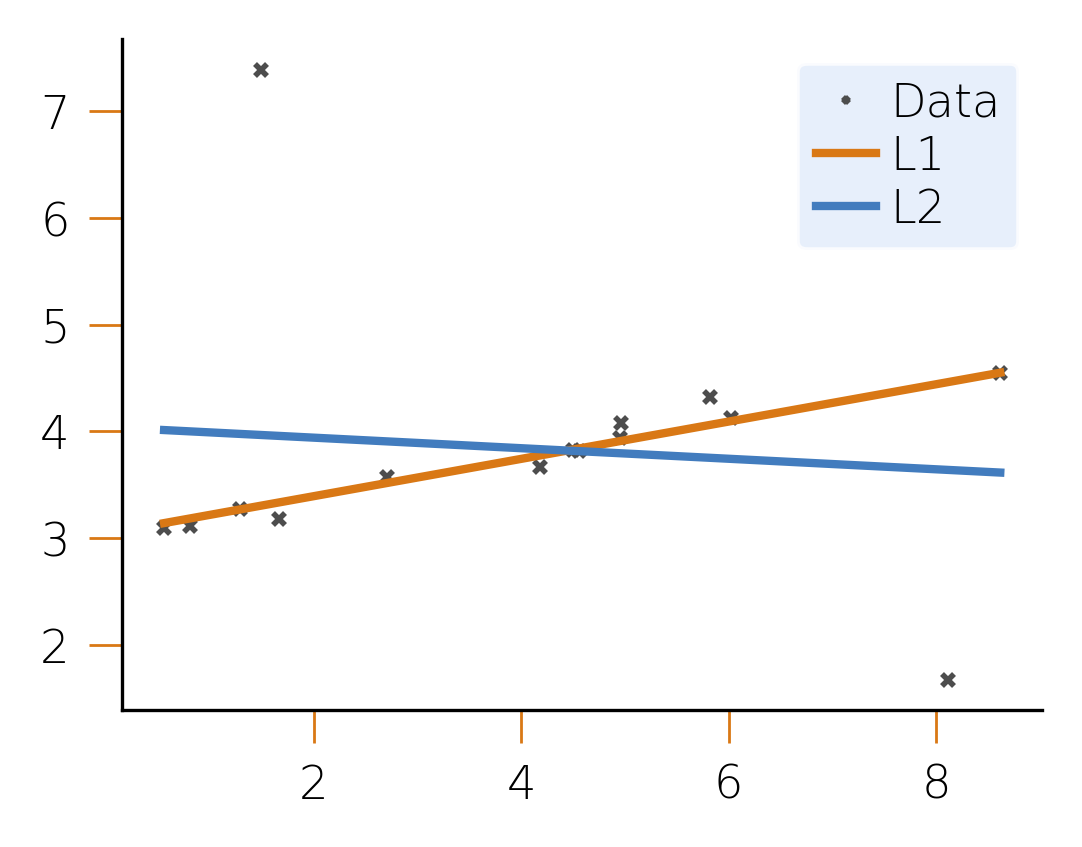

In [20]:
# adjust data by adding outlyers
y2 = y.copy()
y2[3] += 4
y2[13] -= 3

# refit the lines
xopt12 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y2))
xopt22 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y2))

plt.plot(x,y2, marker='x',linestyle='None', label='Data')
plt.plot(x,xopt12[0]*x +xopt12[1], label= 'L1')
plt.plot(x,xopt22[0]*x +xopt22[1], label= 'L2')
plt.legend()

## Reconstruction of a Simple Signal


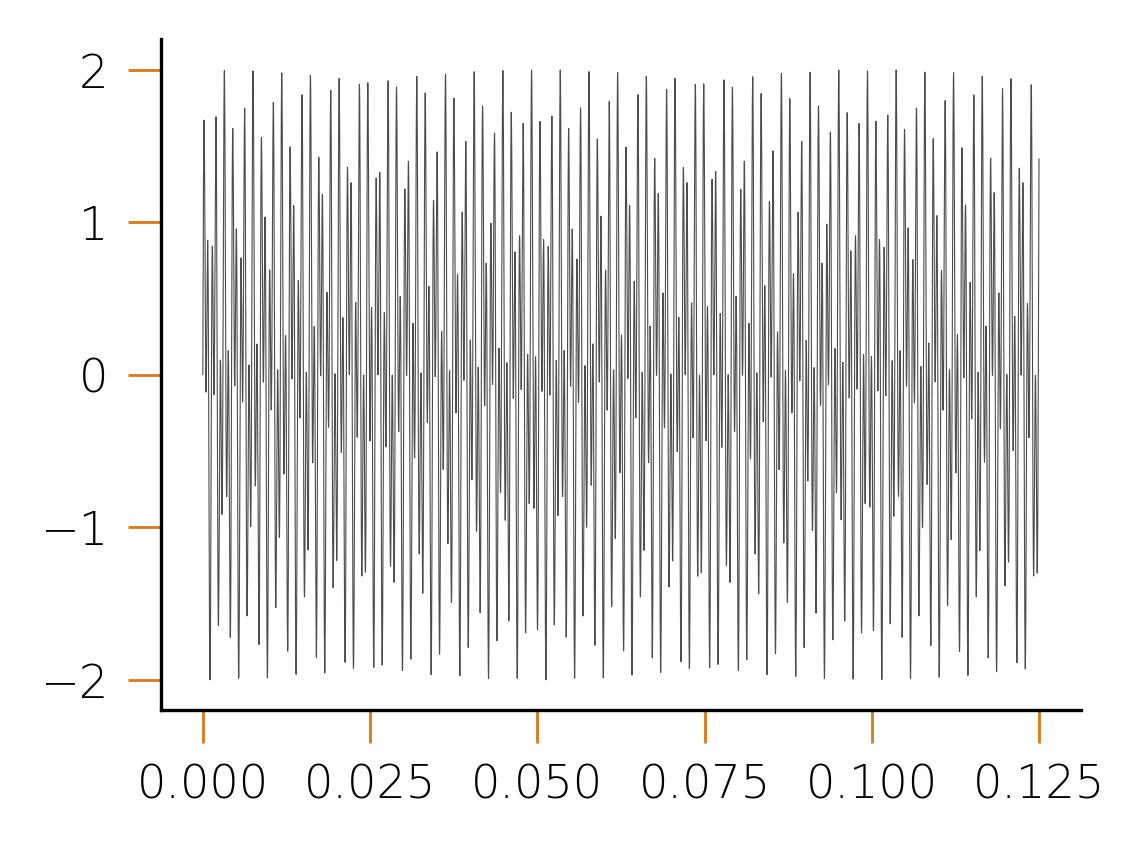

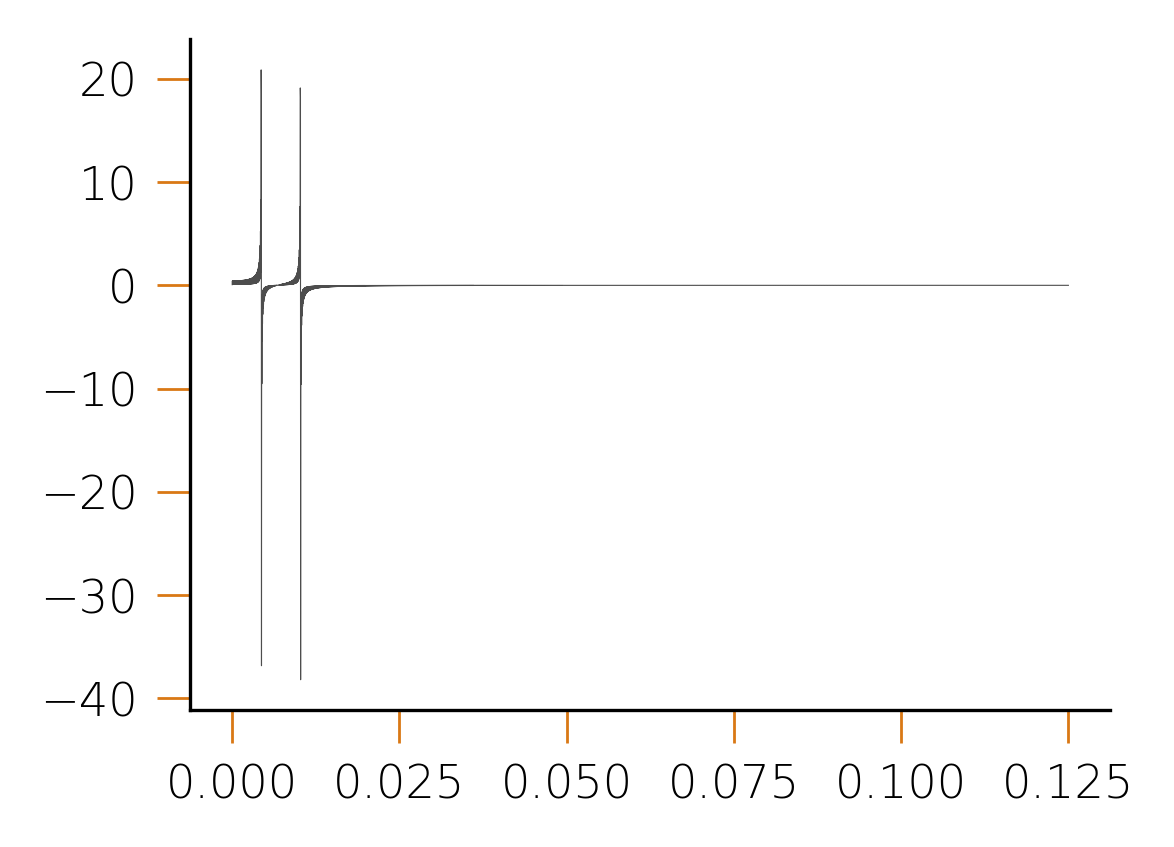

In [21]:
# sum of two sinusoids
n = 5000 # number of samples
t = np.linspace(0, 1/8, n) # time vector
y = np.sin(1394 * np.pi * t) + np.sin(3266 * np.pi * t) # signal
yt = spfft.dct(y, norm='ortho') # DCT of the signal, Discrete Cosine Transform ,Fourier Transform


plt.plot(t, y, linewidth=.2)
plt.figure()
plt.plot(t, yt, linewidth=.2)

Now imagine sampling 10% of the temporal signal (see below)

(5000,) (500,)


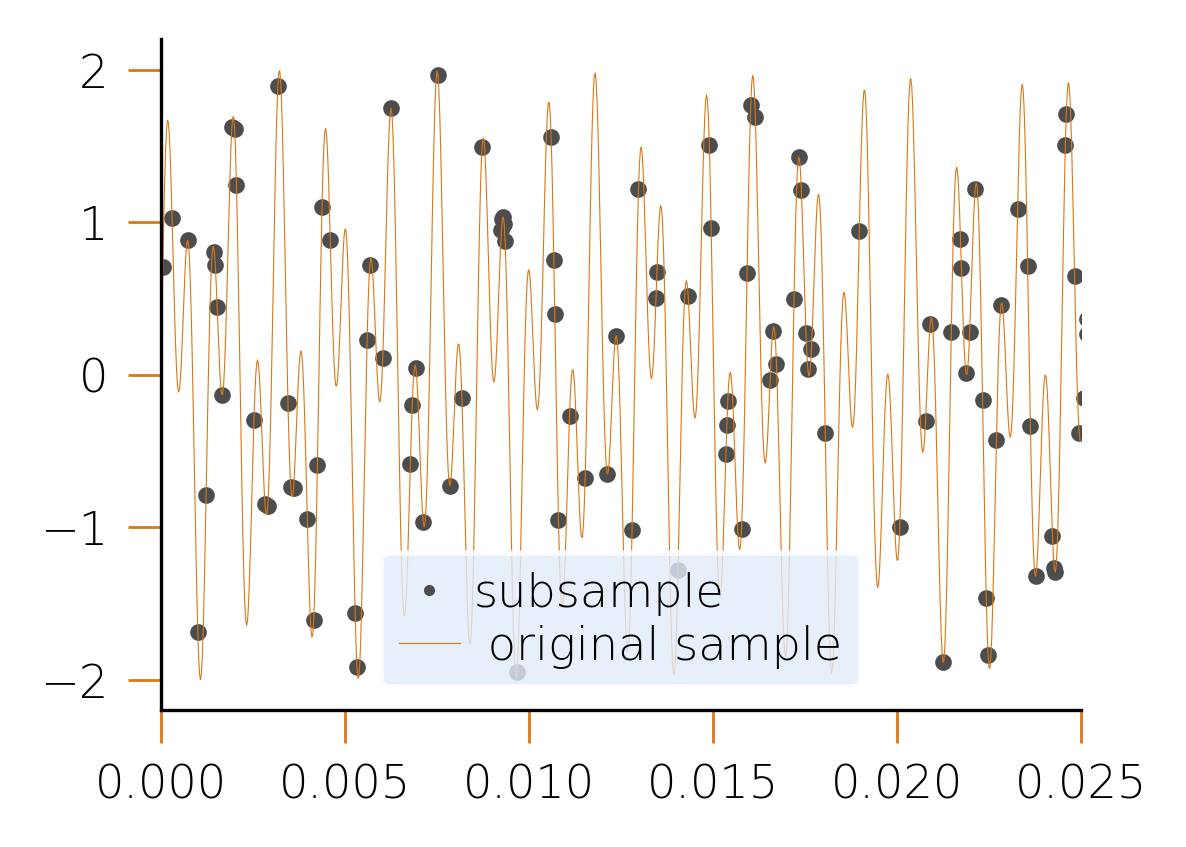

<Figure size 1260x944.8 with 0 Axes>

In [27]:
# extract small sample of signal
m = 500 # 10% sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
t2 = t[ri] #time vector resampled
y2 = y[ri] # signal resampled

# plt.plot(t2, y2, linewidth=.2)
plt.plot(t2, y2, linewidth=.2, marker='o',linestyle='None', label='subsample')
plt.plot(t, y, linewidth=.2,  label=' original sample')
plt.legend()
plt.xlim(0,0.025)
plt.figure()

print(y.shape,y2.shape)


Compressed sensing in this context is made possible by the fact that the signal’s frequency content is highly sparse. This is where the L1 norm comes into play. What we want to do is, out of all possible signals, locate the simplest one that matches up with the known data. In other words, we want to use a minimization routine to find a set of frequencies satisfying two conditions: (a) the underlying signal matches up exactly (or as closely as possible) with that of our data; and (b) the L1 norm of the frequencies is minimized. Such a routine will yield a sparse solution – exactly what we want.

In Python, there are a couple ways to accomplish this. Perhaps the easiest is to utilize the convex optimization library CVXPY. Use the code below to minimize the norm of the signal’s frequencies with the constraint that candidate signals should match up exactly with our incomplete samples.

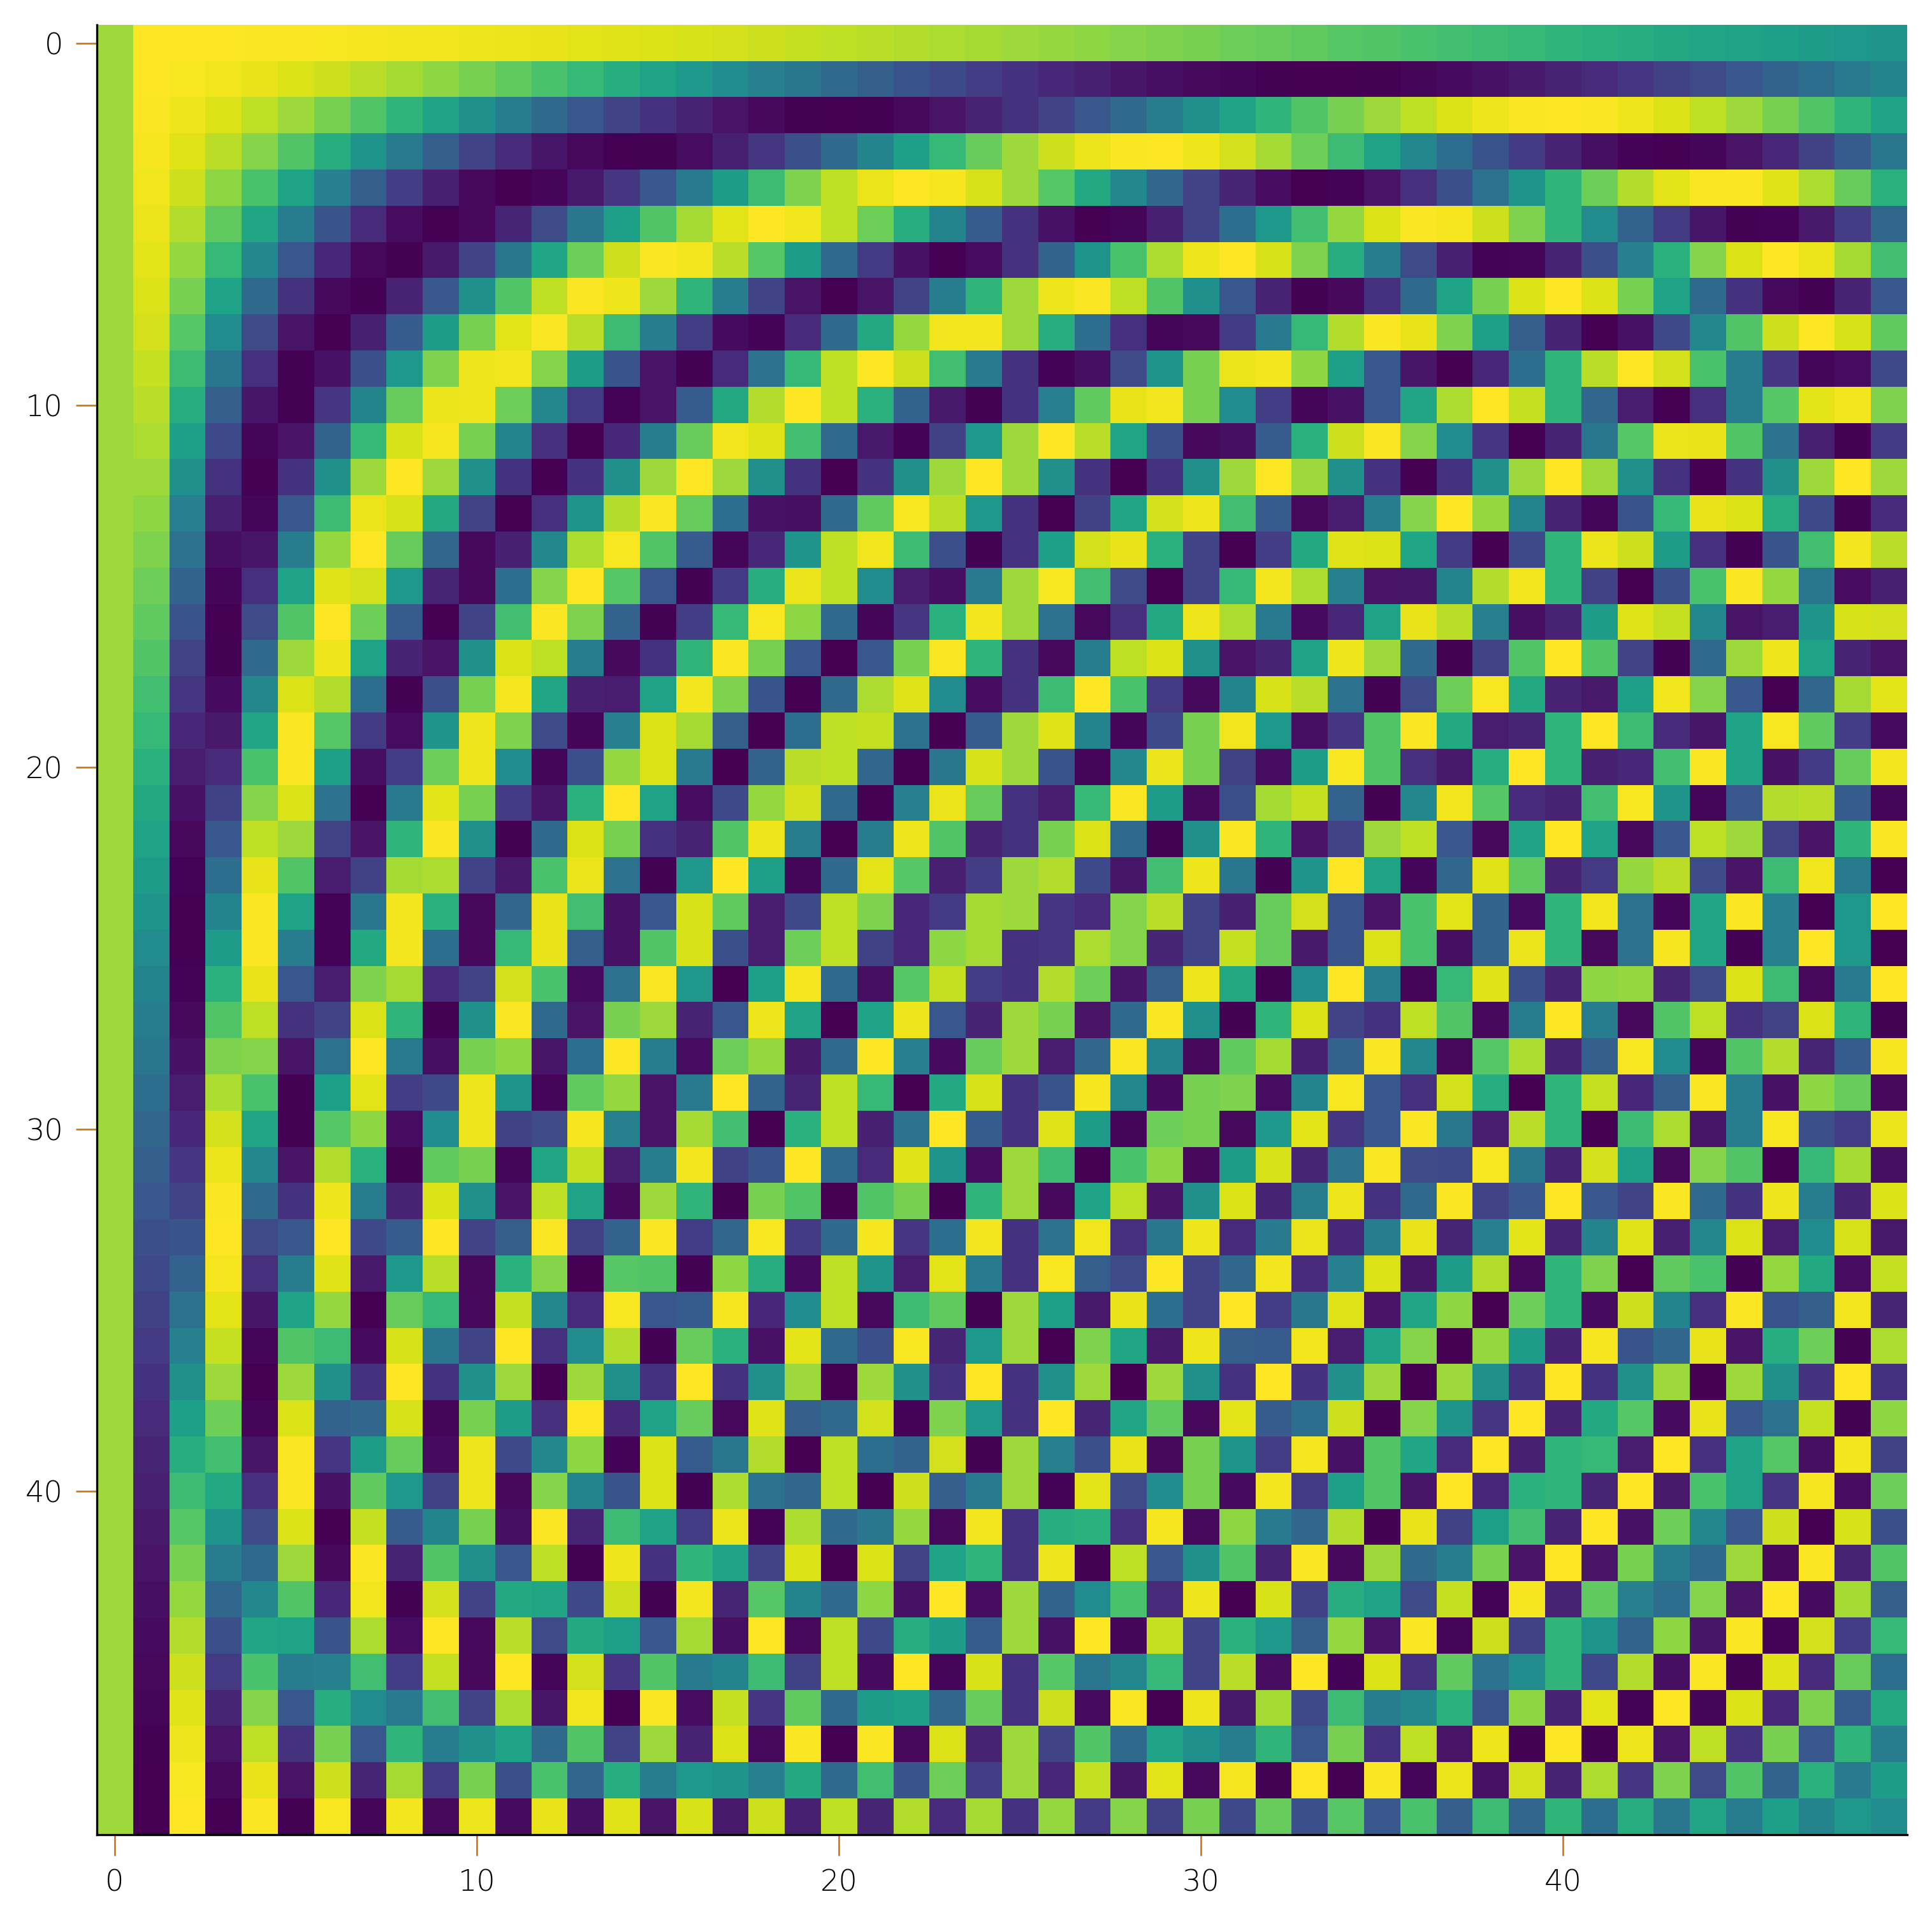

In [39]:
# create idct matrix operator in order to perform inverse DCT
A = spfft.idct(np.identity(int(n/100)), norm='ortho', axis=0)
#A = A[ri] # extract small sample of idct matrix, ri is the indices of the small sample
fig = plt.figure(figsize=(10,10))
plt.imshow(A)


In [79]:


# do L1 optimization
vx = cvx.Variable(n) # variable for the coefficients
objective = cvx.Minimize(cvx.norm(vx, 1)) # L1 norm
constraints = [A*vx == y2] # equality constraint Ax = y , y2 is the small sample of the signal
prob = cvx.Problem(objective, constraints) # create problem
result = prob.solve(verbose=True) # solve problem

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) May 13 11:27:03 AM: Your problem has 5000 variables, 1 constraints, and 0 parameters.
(CVXPY) May 13 11:27:03 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 13 11:27:03 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 13 11:27:03 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 13 11:27:03 AM: Compiling problem (target solver=ECOS).
(CVXPY) May 13 11:27:03 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

/home/gsilvi/miniforge3/lib/python3.9/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) May 13 11:27:05 AM: Applying reduction ECOS
(CVXPY) May 13 11:27:06 AM: Finished problem compilation (took 2.455e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) May 13 11:27:06 AM: Invoking solver ECOS  to obtain a solution.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) May 13 11:28:30 AM: Problem status: optimal
(CVXPY) May 13 11:28:30 AM: Optimal value: 3.227e+02
(CVXPY) May 13 11:28:30 AM: Compilation took 2.455e+00 seconds
(CVXPY) May 13 11:28:30 AM: Solver (including time spent in interface) took 8.412e+01 seconds


In order to perform the minimization, we must somehow finagle our problem into a linear system of equations:

Ax=b

Specifically, we want to derive a matrix A that can be multiplied with a solution candidate x to yield b, a vector containing the data samples. In the context of our current problem, the candidate solution x exists in the frequency domain, while the known data b exists in the temporal domain. Clearly, the matrix A performs both a sampling and a transformation from spectral to temporal domains.

Compressed sensing really comes down to being able to correctly derive the A operator. Fortunately, there’s a methodology. Start off by letting f be the target signal in vector form (if your signal is 2-dimensional or higher, flatten it) and ϕ be the sampling matrix. Then:

b=ϕf

Now let ψ be the matrix that transforms a signal from the spectral domain to the temporal domain. Given the solution x in the frequency domain, it follows that:

ψx=f

Combining the two equations yields:

Ax=bwhere A≡ϕψ

So, A is simply made up of rows sampled from the domain transform matrix ψ. The ψ matrix is easy to construct – it is the inverse discrete cosine transform acting upon the columns of the identity matrix. The matrix product ψx is the equivalent to doing idct(x).

Now that we’ve constructed the A matrix and run the minimization, we can reconstruct the signal by transforming the solution out of the frequency domain and back into the temporal. Below, on the left, is the original signal and its frequency content. On the right is our L1 approximation. I’d say that’s pretty good for only using 10% of the data!

(0.0, 500.0)

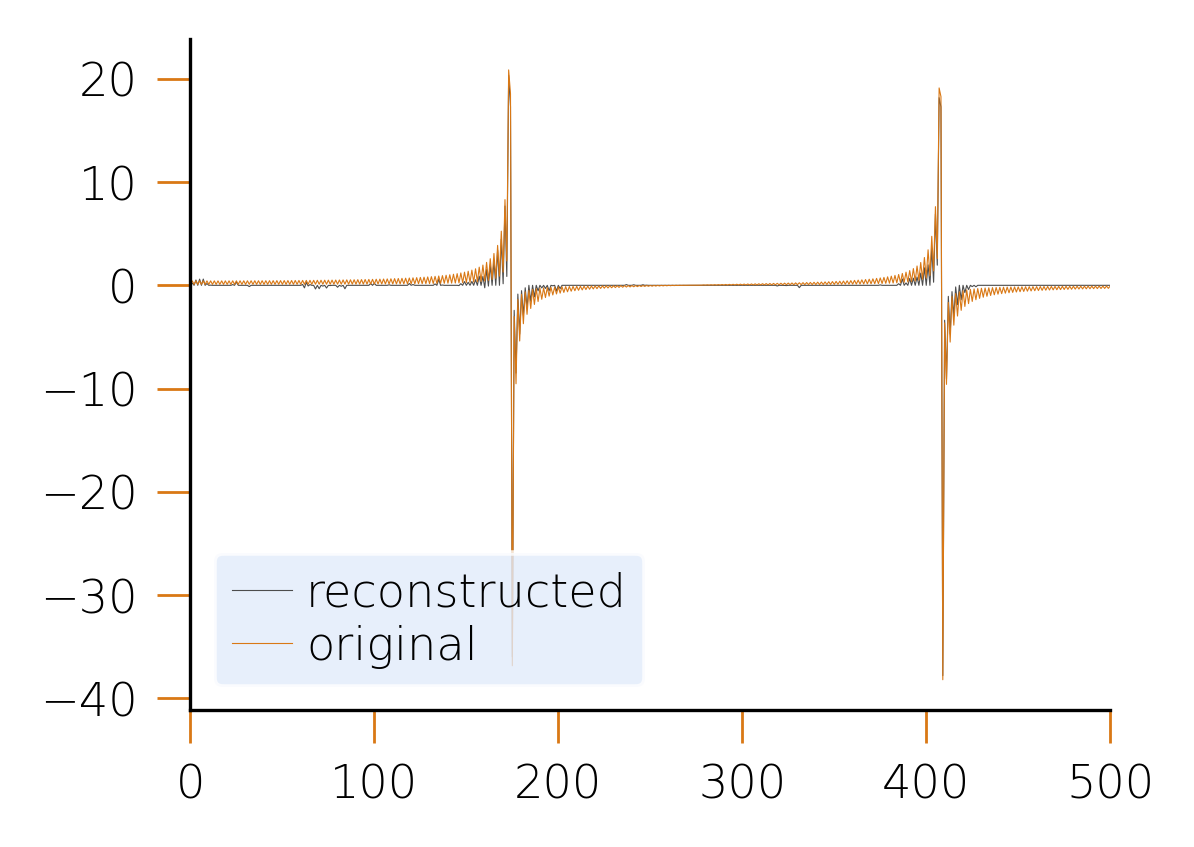

In [81]:
plt.plot(vx.value, linewidth=.2, label='reconstructed')
plt.plot(yt, linewidth=.2 , label='original')
plt.legend()
plt.xlim(0,500)

(0.0, 500.0)

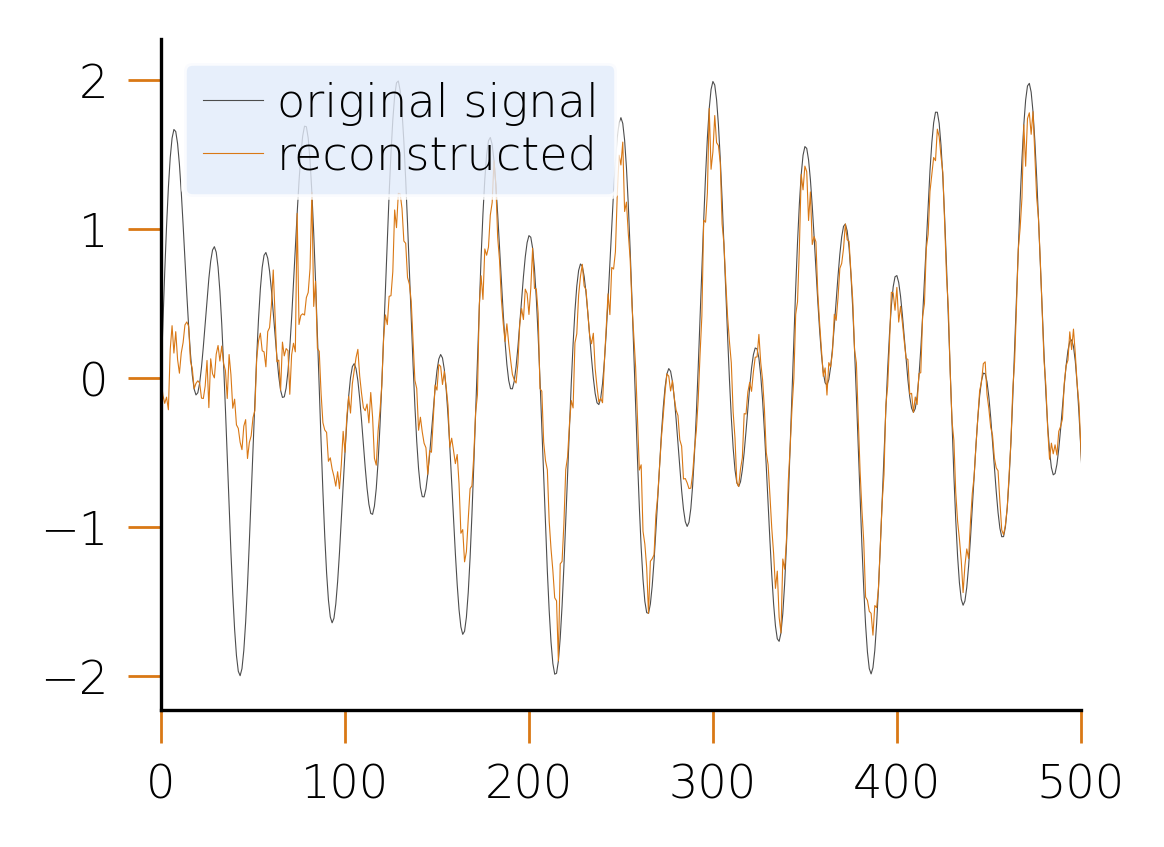

In [82]:
# reconstruct signal
x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)

plt.plot(y, linewidth=.2, label='original signal')
plt.plot(sig, linewidth=.2, label='reconstructed')
plt.legend()
plt.xlim(0,500,)